# Final Quantization Benchmark: DistilBERT on SST-2

**Native-Only Execution**: This notebook only runs quantization formats that are natively supported by the hardware.

**Formats Tested:**
- FP32 (Baseline)
- FP16 (Half Precision)
- BF16 (BFloat16) - Only if natively supported
- Mixed Precision (torch.autocast)

**Metrics:**
- Latency (ms/batch)
- Throughput (samples/second)
- Accuracy (%)
- Energy (mJ/sample)
- Power (W)
- Model Size (MB)

## Setup and Imports

In [16]:
import torch
import torch.nn as nn
from transformers import AutoModelForSequenceClassification
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
import threading
import subprocess
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: Tesla T4
CUDA version: 12.4


## Check Native Format Support

In [17]:
# Check which formats are natively supported
device = "cuda" if torch.cuda.is_available() else "cpu"

# FP32 and FP16 are always supported on CUDA
FP32_SUPPORTED = True
FP16_SUPPORTED = torch.cuda.is_available()

# BF16 requires Ampere or newer (compute capability >= 8.0)
BF16_SUPPORTED = False
if torch.cuda.is_available():
    BF16_SUPPORTED = torch.cuda.is_bf16_supported()

# Mixed precision (autocast) is supported on CUDA
MIXED_SUPPORTED = torch.cuda.is_available()

print("="*70)
print("NATIVE FORMAT SUPPORT")
print("="*70)
print(f"FP32:            {'✓ Supported' if FP32_SUPPORTED else '✗ Not supported'}")
print(f"FP16:            {'✓ Supported' if FP16_SUPPORTED else '✗ Not supported'}")
print(f"BF16:            {'✓ Supported' if BF16_SUPPORTED else '✗ Not supported (requires Ampere+)'}")
print(f"Mixed Precision: {'✓ Supported' if MIXED_SUPPORTED else '✗ Not supported'}")
print("="*70)

# Build list of formats to test
FORMATS_TO_TEST = []
if FP32_SUPPORTED:
    FORMATS_TO_TEST.append('fp32')
if FP16_SUPPORTED:
    FORMATS_TO_TEST.append('fp16')
if BF16_SUPPORTED:
    FORMATS_TO_TEST.append('bf16')
if MIXED_SUPPORTED:
    FORMATS_TO_TEST.append('mixed')

print(f"\nFormats to benchmark: {FORMATS_TO_TEST}")

NATIVE FORMAT SUPPORT
FP32:            ✓ Supported
FP16:            ✓ Supported
BF16:            ✓ Supported
Mixed Precision: ✓ Supported

Formats to benchmark: ['fp32', 'fp16', 'bf16', 'mixed']


## Load Tokenized Dataset

In [18]:
import os
cwd = os.getcwd()

# Search for tokenized dataset
possible_paths = [
    Path(cwd) / ".." / "datasets" / "tokenized_data",
    Path(cwd) / "datasets" / "tokenized_data",
    Path(cwd) / "energy_aware_quantization" / "datasets" / "tokenized_data",
]

dataset_path = None
for path in possible_paths:
    if path.exists() and (path / "input_ids.pt").exists():
        dataset_path = path
        break

if dataset_path is None:
    current = Path(cwd)
    for _ in range(5):
        test_path = current / "datasets" / "tokenized_data"
        if test_path.exists() and (test_path / "input_ids.pt").exists():
            dataset_path = test_path
            break
        current = current.parent

if dataset_path is None:
    raise FileNotFoundError("Could not find tokenized dataset. Please run taara-day-1-2-tokenized-dataset.ipynb first.")

print(f"Loading dataset from: {dataset_path}")

# Load tensors
input_ids = torch.load(dataset_path / "input_ids.pt", map_location='cpu')
attention_mask = torch.load(dataset_path / "attention_mask.pt", map_location='cpu')
labels = torch.load(dataset_path / "labels.pt", map_location='cpu')

print(f"✓ Loaded {input_ids.shape[0]} samples")
print(f"  Input shape: {input_ids.shape}")
print(f"  Device: {input_ids.device}")

Loading dataset from: /kaggle/working/energy_aware_quantization/datasets/tokenized_data
✓ Loaded 50 samples
  Input shape: torch.Size([50, 128])
  Device: cpu


## Power Monitoring Utility

In [19]:
class PowerLogger:
    """Background thread for GPU power monitoring using nvidia-smi"""
    
    def __init__(self, poll_interval_ms=50, gpu_index=0):
        self.poll_interval_ms = poll_interval_ms
        self.gpu_index = gpu_index
        self.power_samples = []
        self.running = False
        self.thread = None
        
    def _monitor_power(self):
        """Background monitoring loop"""
        while self.running:
            try:
                result = subprocess.run(
                    ['nvidia-smi', '--query-gpu=power.draw', '--format=csv,noheader,nounits'],
                    capture_output=True,
                    text=True,
                    timeout=1.0
                )
                if result.returncode == 0:
                    # Handle multiple GPU power values (one per line)
                    power_lines = result.stdout.strip().split('\n')
                    
                    # Use the specified GPU index (default: 0)
                    if len(power_lines) > self.gpu_index:
                        power_str = power_lines[self.gpu_index].strip()
                        power_w = float(power_str)
                        self.power_samples.append(power_w)
                    else:
                        # If only one GPU, use first value
                        power_w = float(power_lines[0].strip())
                        self.power_samples.append(power_w)
            except (ValueError, IndexError) as e:
                # Skip malformed readings
                pass
            except Exception as e:
                print(f"Warning: Failed to read power: {e}")
            
            time.sleep(self.poll_interval_ms / 1000.0)
    
    def start(self):
        """Start power monitoring in background thread"""
        self.power_samples = []
        self.running = True
        self.thread = threading.Thread(target=self._monitor_power, daemon=True)
        self.thread.start()
    
    def stop(self):
        """Stop power monitoring and return statistics"""
        self.running = False
        if self.thread:
            self.thread.join(timeout=2.0)
        
        if len(self.power_samples) == 0:
            return {'mean_power_w': 0, 'std_power_w': 0, 'num_samples': 0}
        
        return {
            'mean_power_w': np.mean(self.power_samples),
            'std_power_w': np.std(self.power_samples),
            'num_samples': len(self.power_samples)
        }

# Test power logger
if torch.cuda.is_available():
    print("Testing power logger...")
    
    # First, check how many GPUs nvidia-smi reports
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=power.draw', '--format=csv,noheader,nounits'],
            capture_output=True,
            text=True,
            timeout=2.0
        )
        power_lines = result.stdout.strip().split('\n')
        num_power_readings = len(power_lines)
        print(f"  Detected {num_power_readings} power reading(s) from nvidia-smi")
        
        if num_power_readings > 1:
            print(f"  Note: Multiple power values detected. Using GPU 0 for monitoring.")
            print(f"  Current readings: {', '.join([f'{p.strip()}W' for p in power_lines])}")
    except Exception as e:
        print(f"  Warning: Could not detect GPU configuration: {e}")
    
    # Test the logger
    logger = PowerLogger(poll_interval_ms=50, gpu_index=0)
    logger.start()
    time.sleep(1.0)
    stats = logger.stop()
    print(f"✓ Power logger working: {stats['mean_power_w']:.2f}W (n={stats['num_samples']} samples)")
else:
    print("⚠️  GPU not available, power monitoring disabled")

Testing power logger...
  Detected 2 power reading(s) from nvidia-smi
  Note: Multiple power values detected. Using GPU 0 for monitoring.
  Current readings: 26.94W, 9.16W
✓ Power logger working: 26.95W (n=12 samples)


## Model Loading Functions

In [20]:
MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english"

def load_model(precision: str, device: str = "cuda"):
    """
    Load model with specified precision.
    
    Args:
        precision: 'fp32', 'fp16', 'bf16', or 'mixed'
        device: 'cuda' or 'cpu'
    
    Returns:
        model, model_size_mb
    """
    print(f"Loading {precision.upper()} model...")
    
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2
    )
    
    # Apply precision
    if precision == 'fp16':
        model = model.half()
    elif precision == 'bf16':
        model = model.to(dtype=torch.bfloat16)
    elif precision == 'mixed':
        # Mixed precision uses FP32 model + autocast during inference
        pass
    
    model = model.to(device)
    model.eval()
    
    # Calculate model size
    model_size_mb = sum(p.element_size() * p.nelement() for p in model.parameters()) / (1024 ** 2)
    
    print(f"  ✓ Size: {model_size_mb:.2f} MB")
    print(f"  ✓ Dtype: {next(model.parameters()).dtype}")
    
    return model, model_size_mb

## Benchmark Function (Lab 3 Methodology)

In [21]:
def benchmark_model(
    model,
    input_ids,
    attention_mask,
    labels,
    name: str,
    device: str,
    num_batches: int = 100,
    warmup_batches: int = 10,
    use_autocast: bool = False
):
    """
    Benchmark model following Lab 3 methodology.
    
    4-phase process:
    1. Warmup
    2. Start power logger
    3. Run benchmark (measure latency + accuracy)
    4. Compute metrics
    """
    print(f"\n{'='*70}")
    print(f"Benchmarking: {name}")
    print(f"{'='*70}")
    
    # Move data to device
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)
    
    batch_size = input_ids.shape[0]
    
    # [PHASE 1/4] Warmup
    print(f"[1/4] Warmup ({warmup_batches} batches)...")
    with torch.no_grad():
        for _ in range(warmup_batches):
            if use_autocast:
                with torch.autocast(device_type='cuda', dtype=torch.float16):
                    _ = model(input_ids=input_ids, attention_mask=attention_mask)
            else:
                _ = model(input_ids=input_ids, attention_mask=attention_mask)
    
    if device == "cuda":
        torch.cuda.synchronize()
    
    # [PHASE 2/4] Start power logger
    print(f"[2/4] Starting power logger...")
    power_logger = None
    if device == "cuda":
        power_logger = PowerLogger(poll_interval_ms=50)
        power_logger.start()
        time.sleep(0.5)  # Let logger stabilize
    
    # [PHASE 3/4] Run benchmark
    print(f"[3/4] Running benchmark ({num_batches} batches)...")
    latencies = []
    correct = 0
    total = 0
    
    benchmark_start = time.perf_counter()
    
    with torch.no_grad():
        for i in range(num_batches):
            if device == "cuda":
                torch.cuda.synchronize()
            
            batch_start = time.perf_counter()
            
            if use_autocast:
                with torch.autocast(device_type='cuda', dtype=torch.float16):
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            else:
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            if device == "cuda":
                torch.cuda.synchronize()
            
            batch_end = time.perf_counter()
            latencies.append(batch_end - batch_start)
            
            # Calculate accuracy for this batch
            predictions = torch.argmax(outputs.logits, dim=-1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            
            if (i + 1) % 25 == 0:
                print(f"    Progress: {i+1}/{num_batches}", end='\r')
    
    benchmark_end = time.perf_counter()
    print()  # New line after progress
    
    # Stop power logger
    power_stats = None
    if power_logger:
        time.sleep(0.5)  # Let final samples collect
        power_stats = power_logger.stop()
    
    # [PHASE 4/4] Compute metrics
    print(f"[4/4] Computing metrics...")
    
    total_time_s = benchmark_end - benchmark_start
    mean_latency_ms = np.mean(latencies) * 1000
    std_latency_ms = np.std(latencies) * 1000
    accuracy = 100.0 * correct / total
    throughput = total / total_time_s  # samples per second
    
    # Energy calculations
    mean_power_w = 0
    energy_per_sample_mj = 0
    if power_stats and power_stats['num_samples'] > 0:
        mean_power_w = power_stats['mean_power_w']
        total_energy_j = mean_power_w * total_time_s
        energy_per_sample_mj = (total_energy_j / total) * 1000  # Convert to mJ
    
    results = {
        'name': name,
        'mean_latency_ms': mean_latency_ms,
        'std_latency_ms': std_latency_ms,
        'accuracy': accuracy,
        'throughput': throughput,
        'mean_power_w': mean_power_w,
        'energy_per_sample_mj': energy_per_sample_mj,
        'total_time_s': total_time_s,
        'total_samples': total
    }
    
    print(f"\n📊 Results:")
    print(f"  Latency:    {mean_latency_ms:.3f} ± {std_latency_ms:.3f} ms/batch")
    print(f"  Throughput: {throughput:.1f} samples/sec")
    print(f"  Accuracy:   {accuracy:.2f}%")
    if power_stats:
        print(f"  Power:      {mean_power_w:.2f} W")
        print(f"  Energy:     {energy_per_sample_mj:.2f} mJ/sample")
    
    return results

## Run All Benchmarks

In [22]:
all_results = []
model_sizes = {}

for precision in FORMATS_TO_TEST:
    try:
        # Load model
        model, model_size_mb = load_model(precision, device=device)
        model_sizes[precision] = model_size_mb
        
        # Benchmark
        use_autocast = (precision == 'mixed')
        results = benchmark_model(
            model=model,
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            name=precision.upper(),
            device=device,
            num_batches=100,
            warmup_batches=10,
            use_autocast=use_autocast
        )
        
        results['model_size_mb'] = model_size_mb
        all_results.append(results)
        
        # Clean up
        del model
        if device == "cuda":
            torch.cuda.empty_cache()
        
        # Small delay between benchmarks
        time.sleep(2)
        
    except Exception as e:
        print(f"\n❌ Error benchmarking {precision}: {e}")
        continue

print(f"\n{'='*70}")
print("ALL BENCHMARKS COMPLETE")
print(f"{'='*70}")

Loading FP32 model...
  ✓ Size: 255.41 MB
  ✓ Dtype: torch.float32

Benchmarking: FP32
[1/4] Warmup (10 batches)...
[2/4] Starting power logger...
[3/4] Running benchmark (100 batches)...
    Progress: 100/100
[4/4] Computing metrics...

📊 Results:
  Latency:    144.672 ± 2.045 ms/batch
  Throughput: 344.7 samples/sec
  Accuracy:   86.00%
  Power:      66.88 W
  Energy:     194.04 mJ/sample
Loading FP16 model...
  ✓ Size: 127.71 MB
  ✓ Dtype: torch.float16

Benchmarking: FP16
[1/4] Warmup (10 batches)...
[2/4] Starting power logger...
[3/4] Running benchmark (100 batches)...
    Progress: 100/100
[4/4] Computing metrics...

📊 Results:
  Latency:    30.493 ± 1.486 ms/batch
  Throughput: 1619.6 samples/sec
  Accuracy:   86.00%
  Power:      62.79 W
  Energy:     38.77 mJ/sample
Loading BF16 model...
  ✓ Size: 127.71 MB
  ✓ Dtype: torch.bfloat16

Benchmarking: BF16
[1/4] Warmup (10 batches)...
[2/4] Starting power logger...
[3/4] Running benchmark (100 batches)...
    Progress: 100/100
[4

## Results Summary Table

In [23]:
# Create results dataframe
df_results = pd.DataFrame(all_results)

# Calculate speedup vs FP32
if 'fp32' in [r['name'].lower() for r in all_results]:
    fp32_latency = df_results[df_results['name'].str.upper() == 'FP32']['mean_latency_ms'].values[0]
    df_results['speedup_vs_fp32'] = fp32_latency / df_results['mean_latency_ms']
    
    fp32_energy = df_results[df_results['name'].str.upper() == 'FP32']['energy_per_sample_mj'].values[0]
    if fp32_energy > 0:
        df_results['energy_reduction_vs_fp32'] = fp32_energy / df_results['energy_per_sample_mj']
    else:
        df_results['energy_reduction_vs_fp32'] = 1.0
    
    fp32_size = df_results[df_results['name'].str.upper() == 'FP32']['model_size_mb'].values[0]
    df_results['size_reduction_vs_fp32'] = fp32_size / df_results['model_size_mb']
else:
    df_results['speedup_vs_fp32'] = 1.0
    df_results['energy_reduction_vs_fp32'] = 1.0
    df_results['size_reduction_vs_fp32'] = 1.0

# Reorder columns
column_order = [
    'name',
    'mean_latency_ms',
    'std_latency_ms',
    'speedup_vs_fp32',
    'throughput',
    'accuracy',
    'mean_power_w',
    'energy_per_sample_mj',
    'energy_reduction_vs_fp32',
    'model_size_mb',
    'size_reduction_vs_fp32'
]
df_results = df_results[column_order]

# Display results
print("\n" + "="*100)
print("QUANTIZATION BENCHMARK RESULTS")
print("="*100)
print(df_results.to_string(index=False))
print("="*100)


QUANTIZATION BENCHMARK RESULTS
 name  mean_latency_ms  std_latency_ms  speedup_vs_fp32  throughput  accuracy  mean_power_w  energy_per_sample_mj  energy_reduction_vs_fp32  model_size_mb  size_reduction_vs_fp32
 FP32       144.671869        2.045206         1.000000  344.658304      86.0     66.878239            194.042151                  1.000000     255.413094                     1.0
 FP16        30.492813        1.486470         4.744458 1619.587093      86.0     62.788696             38.768335                  5.005171     127.706547                     2.0
 BF16       220.883487        2.139696         0.654969  225.948433      86.0     65.309922            289.047907                  0.671315     127.706547                     2.0
MIXED        36.065584        1.256535         4.011355 1372.668387      86.0     61.819444             45.035964                  4.308604     255.413094                     1.0


## Statistical Analysis

In [24]:
print("\n" + "="*70)
print("STATISTICAL ANALYSIS")
print("="*70)

# Summary statistics
print("\n1. Latency Statistics (ms/batch):")
for _, row in df_results.iterrows():
    print(f"  {row['name']:12s}: {row['mean_latency_ms']:7.3f} ± {row['std_latency_ms']:6.3f}")

print("\n2. Speedup vs FP32:")
for _, row in df_results.iterrows():
    speedup = row['speedup_vs_fp32']
    print(f"  {row['name']:12s}: {speedup:.2f}x faster")

print("\n3. Energy Efficiency vs FP32:")
for _, row in df_results.iterrows():
    if row['energy_per_sample_mj'] > 0:
        reduction = row['energy_reduction_vs_fp32']
        print(f"  {row['name']:12s}: {reduction:.2f}x more efficient ({row['energy_per_sample_mj']:.2f} mJ/sample)")

print("\n4. Model Size Reduction:")
for _, row in df_results.iterrows():
    reduction = row['size_reduction_vs_fp32']
    print(f"  {row['name']:12s}: {reduction:.2f}x smaller ({row['model_size_mb']:.2f} MB)")

print("\n5. Accuracy Comparison:")
for _, row in df_results.iterrows():
    print(f"  {row['name']:12s}: {row['accuracy']:.2f}%")

# Best performer in each category
print("\n6. Best Performers:")
if len(df_results) > 1:
    fastest = df_results.loc[df_results['mean_latency_ms'].idxmin()]
    print(f"  Fastest:          {fastest['name']} ({fastest['mean_latency_ms']:.3f} ms)")
    
    most_efficient = df_results.loc[df_results['energy_per_sample_mj'].idxmin()]
    if most_efficient['energy_per_sample_mj'] > 0:
        print(f"  Most Efficient:   {most_efficient['name']} ({most_efficient['energy_per_sample_mj']:.2f} mJ/sample)")
    
    smallest = df_results.loc[df_results['model_size_mb'].idxmin()]
    print(f"  Smallest:         {smallest['name']} ({smallest['model_size_mb']:.2f} MB)")
    
    most_accurate = df_results.loc[df_results['accuracy'].idxmax()]
    print(f"  Most Accurate:    {most_accurate['name']} ({most_accurate['accuracy']:.2f}%)")

print("="*70)


STATISTICAL ANALYSIS

1. Latency Statistics (ms/batch):
  FP32        : 144.672 ±  2.045
  FP16        :  30.493 ±  1.486
  BF16        : 220.883 ±  2.140
  MIXED       :  36.066 ±  1.257

2. Speedup vs FP32:
  FP32        : 1.00x faster
  FP16        : 4.74x faster
  BF16        : 0.65x faster
  MIXED       : 4.01x faster

3. Energy Efficiency vs FP32:
  FP32        : 1.00x more efficient (194.04 mJ/sample)
  FP16        : 5.01x more efficient (38.77 mJ/sample)
  BF16        : 0.67x more efficient (289.05 mJ/sample)
  MIXED       : 4.31x more efficient (45.04 mJ/sample)

4. Model Size Reduction:
  FP32        : 1.00x smaller (255.41 MB)
  FP16        : 2.00x smaller (127.71 MB)
  BF16        : 2.00x smaller (127.71 MB)
  MIXED       : 1.00x smaller (255.41 MB)

5. Accuracy Comparison:
  FP32        : 86.00%
  FP16        : 86.00%
  BF16        : 86.00%
  MIXED       : 86.00%

6. Best Performers:
  Fastest:          FP16 (30.493 ms)
  Most Efficient:   FP16 (38.77 mJ/sample)
  Smalles

## Visualization

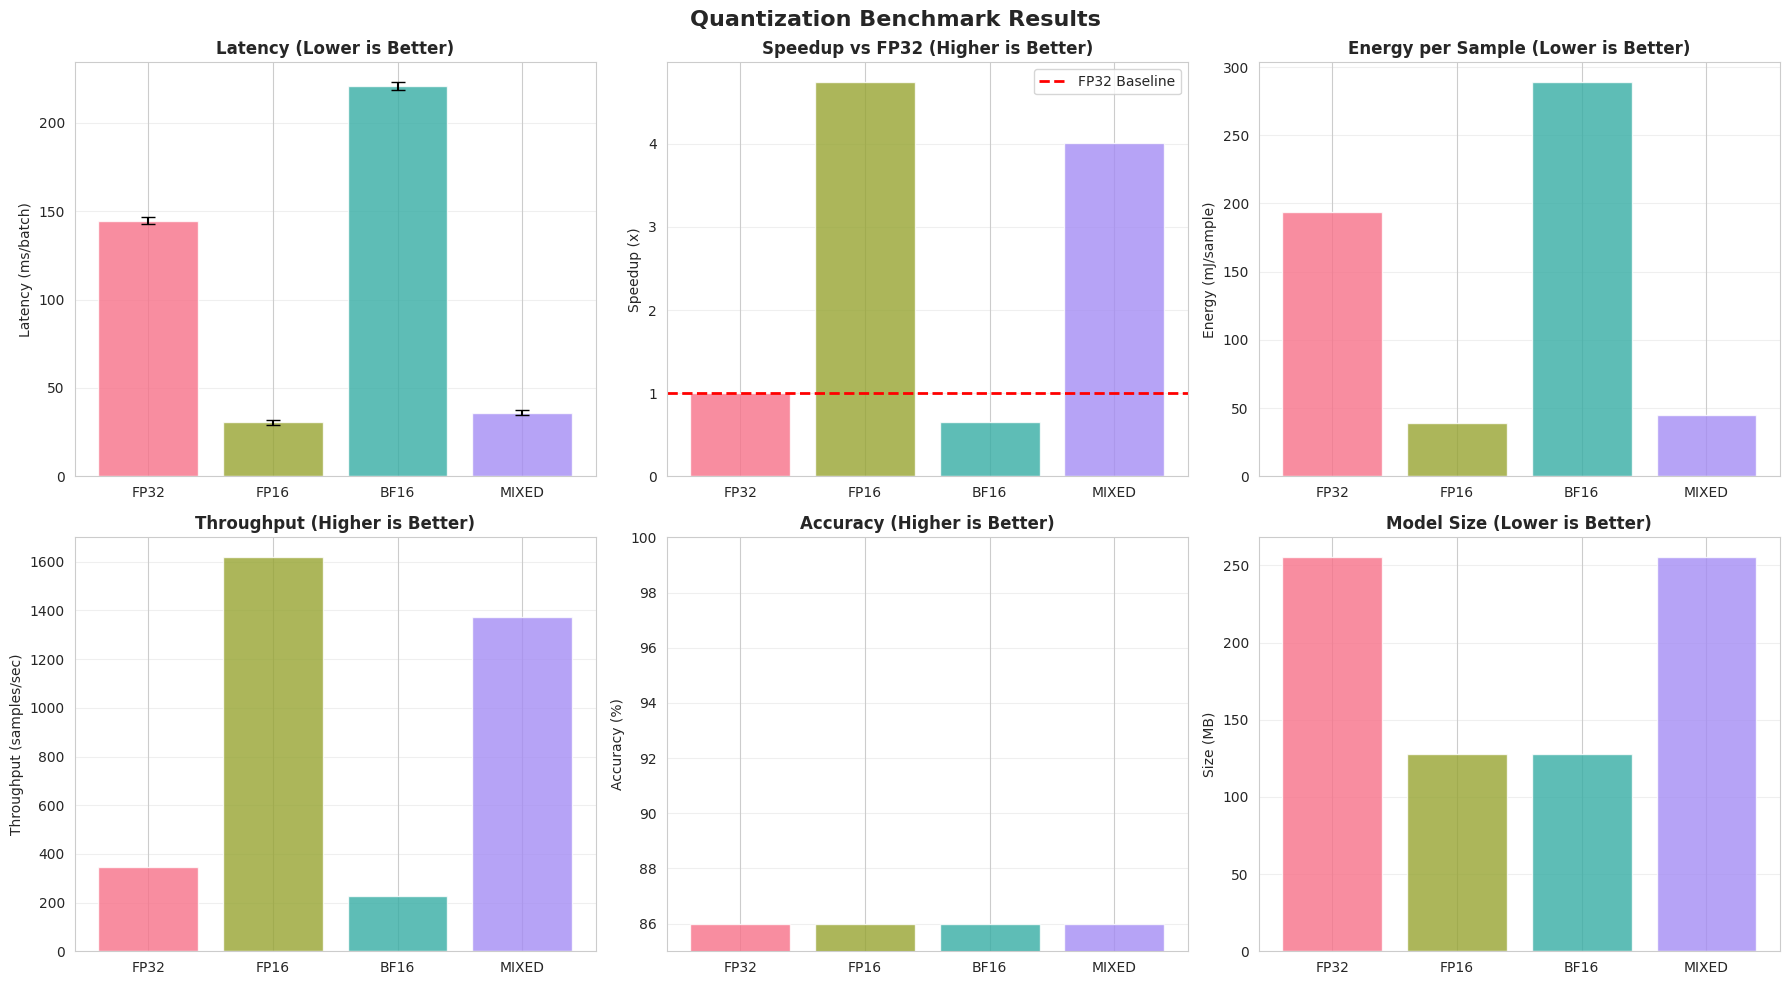


✓ Visualization complete


In [25]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Quantization Benchmark Results', fontsize=16, fontweight='bold')

# Color palette
colors = sns.color_palette('husl', n_colors=len(df_results))

# 1. Latency comparison
ax = axes[0, 0]
bars = ax.bar(df_results['name'], df_results['mean_latency_ms'], color=colors, alpha=0.8)
ax.errorbar(df_results['name'], df_results['mean_latency_ms'], 
            yerr=df_results['std_latency_ms'], fmt='none', color='black', capsize=5)
ax.set_title('Latency (Lower is Better)', fontweight='bold')
ax.set_ylabel('Latency (ms/batch)')
ax.grid(axis='y', alpha=0.3)

# 2. Speedup vs FP32
ax = axes[0, 1]
bars = ax.bar(df_results['name'], df_results['speedup_vs_fp32'], color=colors, alpha=0.8)
ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='FP32 Baseline')
ax.set_title('Speedup vs FP32 (Higher is Better)', fontweight='bold')
ax.set_ylabel('Speedup (x)')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 3. Energy per sample
ax = axes[0, 2]
if df_results['energy_per_sample_mj'].max() > 0:
    bars = ax.bar(df_results['name'], df_results['energy_per_sample_mj'], color=colors, alpha=0.8)
    ax.set_title('Energy per Sample (Lower is Better)', fontweight='bold')
    ax.set_ylabel('Energy (mJ/sample)')
    ax.grid(axis='y', alpha=0.3)
else:
    ax.text(0.5, 0.5, 'Energy data not available', 
            ha='center', va='center', transform=ax.transAxes)
    ax.set_title('Energy per Sample', fontweight='bold')

# 4. Throughput
ax = axes[1, 0]
bars = ax.bar(df_results['name'], df_results['throughput'], color=colors, alpha=0.8)
ax.set_title('Throughput (Higher is Better)', fontweight='bold')
ax.set_ylabel('Throughput (samples/sec)')
ax.grid(axis='y', alpha=0.3)

# 5. Accuracy
ax = axes[1, 1]
bars = ax.bar(df_results['name'], df_results['accuracy'], color=colors, alpha=0.8)
ax.set_title('Accuracy (Higher is Better)', fontweight='bold')
ax.set_ylabel('Accuracy (%)')
ax.set_ylim([min(df_results['accuracy']) - 1, 100])
ax.grid(axis='y', alpha=0.3)

# 6. Model size
ax = axes[1, 2]
bars = ax.bar(df_results['name'], df_results['model_size_mb'], color=colors, alpha=0.8)
ax.set_title('Model Size (Lower is Better)', fontweight='bold')
ax.set_ylabel('Size (MB)')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete")

## Pareto Frontier: Speed vs Accuracy

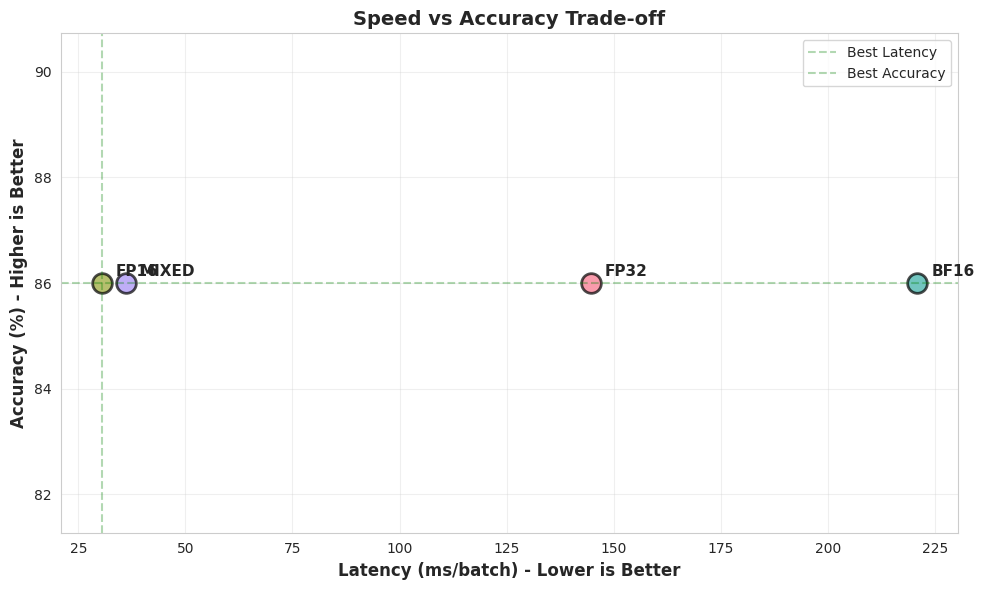


✓ Pareto frontier visualization complete


In [26]:
# Pareto frontier plot: Latency vs Accuracy
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each format
for i, row in df_results.iterrows():
    ax.scatter(row['mean_latency_ms'], row['accuracy'], 
              s=200, c=[colors[i]], alpha=0.7, edgecolors='black', linewidth=2)
    ax.annotate(row['name'], 
               (row['mean_latency_ms'], row['accuracy']),
               xytext=(10, 5), textcoords='offset points',
               fontsize=11, fontweight='bold')

ax.set_xlabel('Latency (ms/batch) - Lower is Better', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy (%) - Higher is Better', fontsize=12, fontweight='bold')
ax.set_title('Speed vs Accuracy Trade-off', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add ideal region (top-left corner)
ax.axvline(x=df_results['mean_latency_ms'].min(), color='green', 
          linestyle='--', alpha=0.3, label='Best Latency')
ax.axhline(y=df_results['accuracy'].max(), color='green', 
          linestyle='--', alpha=0.3, label='Best Accuracy')
ax.legend()

plt.tight_layout()
plt.show()

print("\n✓ Pareto frontier visualization complete")

## Export Results for Further Analysis

In [27]:
# Save results to CSV
output_dir = Path("../results")
output_dir.mkdir(exist_ok=True)

output_file = output_dir / "quantization_benchmark_results.csv"
df_results.to_csv(output_file, index=False)
print(f"\n✓ Results saved to: {output_file}")

# Also save a summary markdown file
summary_file = output_dir / "benchmark_summary.md"
with open(summary_file, 'w') as f:
    f.write("# Quantization Benchmark Summary\n\n")
    f.write(f"**Date:** {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    f.write(f"**Model:** {MODEL_NAME}\n\n")
    f.write(f"**Device:** {device}\n\n")
    if torch.cuda.is_available():
        f.write(f"**GPU:** {torch.cuda.get_device_name(0)}\n\n")
    
    f.write("## Results\n\n")
    f.write(df_results.to_markdown(index=False))
    f.write("\n\n## Key Findings\n\n")
    
    if len(df_results) > 1:
        fastest = df_results.loc[df_results['mean_latency_ms'].idxmin()]
        f.write(f"- **Fastest:** {fastest['name']} ({fastest['speedup_vs_fp32']:.2f}x faster than FP32)\n")
        
        if df_results['energy_per_sample_mj'].max() > 0:
            most_efficient = df_results.loc[df_results['energy_per_sample_mj'].idxmin()]
            f.write(f"- **Most Efficient:** {most_efficient['name']} ({most_efficient['energy_reduction_vs_fp32']:.2f}x more efficient)\n")
        
        smallest = df_results.loc[df_results['model_size_mb'].idxmin()]
        f.write(f"- **Smallest:** {smallest['name']} ({smallest['size_reduction_vs_fp32']:.2f}x size reduction)\n")
        
        most_accurate = df_results.loc[df_results['accuracy'].idxmax()]
        f.write(f"- **Most Accurate:** {most_accurate['name']} ({most_accurate['accuracy']:.2f}%)\n")

print(f"✓ Summary saved to: {summary_file}")

print("\n" + "="*70)
print("BENCHMARK COMPLETE")
print("="*70)


✓ Results saved to: ../results/quantization_benchmark_results.csv
✓ Summary saved to: ../results/benchmark_summary.md

BENCHMARK COMPLETE
